In [1]:
# !pip install pandas seaborn scipy numpy matplotlib

In [2]:
import pandas as pd
import seaborn as sns
from scipy.stats import multinomial
import matplotlib.pyplot as plt
import numpy as np
import itertools
import math

## 1. Read Train Data

In [3]:
df = pd.read_csv('./data/train_data/train_task_3_4.csv')
df.info()
df.groupby('UserId').value_counts()
df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1382727 entries, 0 to 1382726
Data columns (total 6 columns):
 #   Column         Non-Null Count    Dtype
---  ------         --------------    -----
 0   QuestionId     1382727 non-null  int64
 1   UserId         1382727 non-null  int64
 2   AnswerId       1382727 non-null  int64
 3   IsCorrect      1382727 non-null  int64
 4   CorrectAnswer  1382727 non-null  int64
 5   AnswerValue    1382727 non-null  int64
dtypes: int64(6)
memory usage: 63.3 MB


,QuestionId,UserId,AnswerId,IsCorrect,CorrectAnswer,AnswerValue
0,898,2111,280203,1,2,2
1,767,3062,55638,1,3,3
2,165,1156,386475,1,2,2
3,490,1653,997498,1,4,4
4,298,3912,578636,1,3,3
...,...,...,...,...,...,...
1382722,80,2608,57945,1,2,2
1382723,707,2549,584230,0,2,1
1382724,840,5901,1138956,1,1,1
1382725,794,3854,1151183,0,1,3


In [4]:
df.describe()


,QuestionId,UserId,AnswerId,IsCorrect,CorrectAnswer,AnswerValue
count,1.382727e+06,1.382727e+06,1.382727e+06,1.382727e+06,1.382727e+06,1.382727e+06
mean,4.682276e+02,3.036283e+03,7.544279e+05,5.373317e-01,2.390497e+00,2.437992e+00
std,2.735797e+02,1.770599e+03,4.356190e+05,4.986046e-01,1.066479e+00,1.067624e+00
min,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00
25%,2.330000e+02,1.515000e+03,3.772935e+05,0.000000e+00,1.000000e+00,2.000000e+00
50%,4.680000e+02,3.009000e+03,7.544530e+05,1.000000e+00,2.000000e+00,2.000000e+00
75%,7.030000e+02,4.565000e+03,1.131772e+06,1.000000e+00,3.000000e+00,3.000000e+00
max,9.470000e+02,6.147000e+03,1.508916e+06,1.000000e+00,4.000000e+00,4.000000e+00


In [5]:
# check pure unique questions num
qNum = len(df['QuestionId'].unique())
qNum

948

## 2. Calculate selectivity by multinomial entropy of normalized values of AnswerValue

In [6]:
# if selection entropy is close to 0, it means bad distribution(selectivity) of given possible answers
answerValue_value = df.groupby('QuestionId')['AnswerValue'].value_counts(normalize=True)

answerValue_value_list=[]
index=[]

for i in range(0,qNum):
    index.append(i)
    answerValue_value_list.append(multinomial.entropy(1,answerValue_value[i]))

answerValue_entropies = pd.Series(answerValue_value_list, index=index, dtype=float, name='AnswerValue')
answerValue_entropies = (answerValue_entropies - np.mean(answerValue_entropies))/np.std(answerValue_entropies)
print(answerValue_entropies)

0      0.270462
1     -1.290954
2      0.943211
3     -2.176383
4      0.907212
         ...   
943   -0.886257
944    0.848780
945    0.596416
946    0.477750
947   -0.277917
Name: AnswerValue, Length: 948, dtype: float64


<Axes: xlabel='AnswerValue', ylabel='Count'>

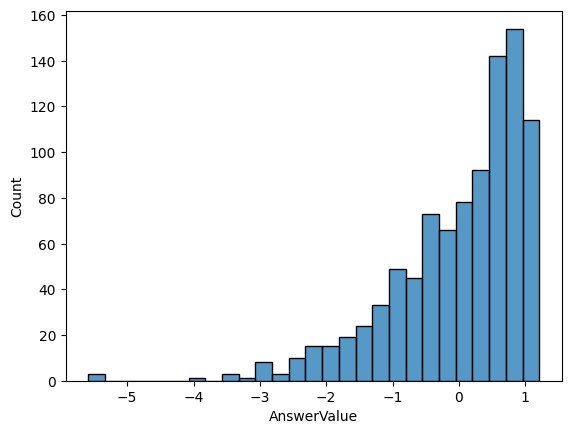

In [7]:
sns.histplot(answerValue_entropies)

## 3. Calculate Correct answer rate by multinomial entropy of normalized values of IsCorrect

In [8]:
# if correctness entropy is close to 0, it means good correct answer rate.
isCorrect_value = df.groupby('QuestionId')['IsCorrect'].value_counts(normalize=True)

isCorrect_value_list=[]
index=[]

for i in range(0,qNum):
    index.append(i)
    isCorrect_value_list.append(multinomial.entropy(1,isCorrect_value[i]))

isCorrect_entropies = pd.Series(isCorrect_value_list, index=index, dtype=float, name='IsCorrect')
isCorrect_entropies = (isCorrect_entropies - np.mean(isCorrect_entropies))/np.std(isCorrect_entropies)
print(isCorrect_entropies)

0      0.646696
1      0.592216
2      0.359719
3     -2.179250
4      0.459543
         ...   
943    0.611566
944   -3.287095
945    0.565577
946    0.691027
947    0.344009
Name: IsCorrect, Length: 948, dtype: float64


<Axes: xlabel='IsCorrect', ylabel='Count'>

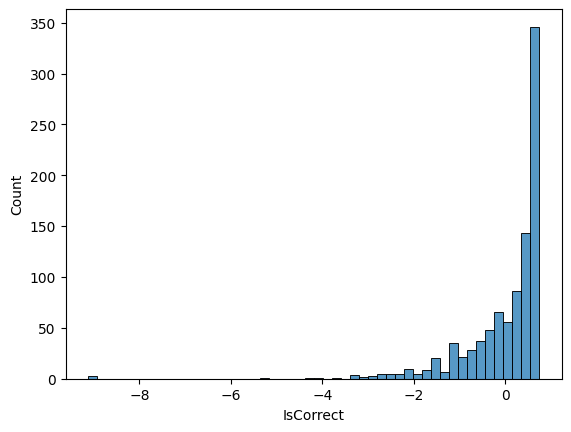

In [9]:
sns.histplot(isCorrect_entropies)

## 4. Calculate Difficulty of question by IsCorrect-UserCorrectRate(each user's correct rate)

In [10]:
# get score of each users
userCorrectRate = df.groupby('UserId')['IsCorrect'].mean()
df['UserCorrectRate'] = df['UserId'].map(userCorrectRate) # map userCorrectRate with userid, get correct rate of each user!

# get question difficulty
difficulty_df = df.groupby(['QuestionId']).agg({'IsCorrect': 'mean', 'UserCorrectRate': 'mean'})
difficulty_df['Difficulty'] = abs(difficulty_df['IsCorrect'] - difficulty_df['UserCorrectRate'])
difficulty_df = difficulty_df.sort_index()
difficulty = difficulty_df.iloc[:,2]

difficulty = (difficulty - np.mean(difficulty))/np.std(difficulty)
print(difficulty)

QuestionId
0     -0.264619
1     -0.843245
2      0.244316
3      1.659576
4      0.147928
         ...   
943   -1.289209
944    2.741336
945   -0.184649
946   -1.231891
947   -0.328292
Name: Difficulty, Length: 948, dtype: float64


<Axes: xlabel='Difficulty', ylabel='Count'>

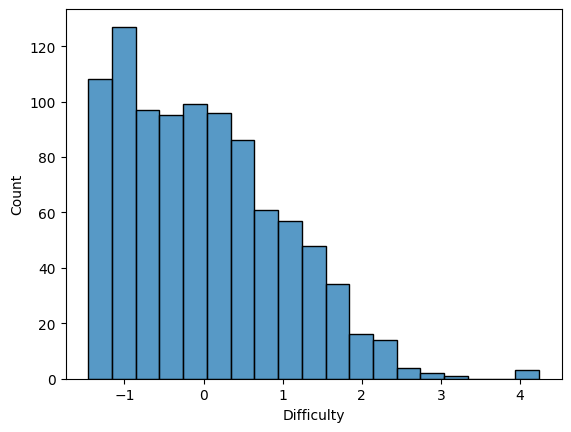

In [11]:
sns.histplot(difficulty)

## 5. Load metadata

In [12]:
answer_meta_data = pd.read_csv('./data/metadata/answer_metadata_task_3_4.csv')

print(answer_meta_data)

         AnswerId             DateAnswered  Confidence  GroupId  QuizId   
0         1451945  2019-10-30 14:34:00.000         NaN        4      32  \
1           45325  2020-01-06 18:53:00.000        75.0      185      66   
2          687013  2020-01-18 10:52:00.000         NaN      235      64   
3           91254  2020-02-29 17:25:00.000         NaN      194      97   
4         1225855  2020-03-06 15:07:00.000         NaN       95     115   
...           ...                      ...         ...      ...     ...   
1508912    880336  2019-12-05 18:56:00.000        75.0       27      84   
1508913    701366  2020-01-20 20:27:00.000         NaN      362      65   
1508914    646214  2019-12-17 19:33:00.000         NaN      170      84   
1508915    346788  2019-10-25 15:00:00.000         NaN       10      73   
1508916    949136  2019-11-01 21:29:00.000        75.0      300      49   

         SchemeOfWorkId  
0               52562.0  
1               52562.0  
2               52562

In [13]:
# load the submission csv file
template = pd.read_csv('./submission/template.csv')

## 6. Compute confidence for each problems in metadata

In [14]:
new_df = df.merge(answer_meta_data, on='AnswerId', how='left') # answerid matches with train data
confidence = new_df[new_df['Confidence'].notnull()] # find not NAN rows
questionId = confidence.groupby('QuestionId')['QuestionId'].agg(lambda x: len(x))

qid = {}

for i in questionId.index:
    qid[i] = questionId[i]

temp = []

for key, value in qid.items():
    temp.append(key)

confidence = confidence[confidence['QuestionId'].isin(temp)]

avg = {}

for i in confidence['QuestionId'].unique():
    part = confidence[confidence['QuestionId']==i]
    avg[i] = part['Confidence'].mean()

confidences = list(avg.values())
template['confidence'] = template['QuestionId'].apply(lambda x: avg[x] if x in avg else np.mean(confidences))
template['z_confidence'] = (template['confidence']-np.mean(template['confidence']))/np.std(template['confidence'])

zconfidence= template['z_confidence']
print(zconfidence)


0     -8.563756e-01
1     -1.548374e-15
2     -8.536644e-01
3      1.196897e+00
4     -1.600884e+00
           ...     
943    1.063146e+00
944   -4.557979e-01
945   -1.951952e-01
946   -2.154513e-01
947    1.312024e-01
Name: z_confidence, Length: 948, dtype: float64


<Axes: xlabel='z_confidence', ylabel='Count'>

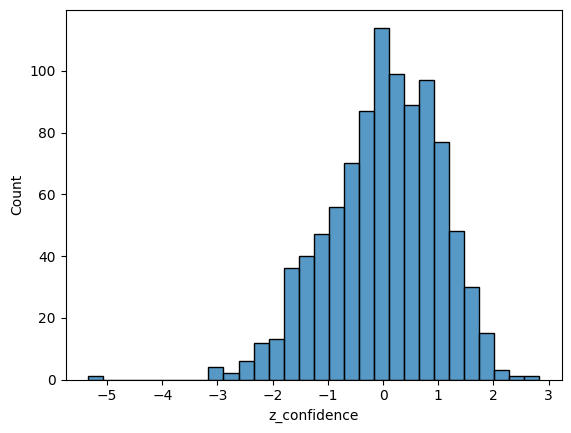

In [15]:
sns.histplot(zconfidence)

## 7. Compute each groups'(each GroupId) correct rate in metadata

In [16]:
def group_entropy(input_df):
    tempDF = input_df.groupby('GroupId')['IsCorrect'].value_counts(normalize=True)
    
    tempDF_list=[]
    index = list(sorted(set(input_df['GroupId'].tolist())))
    
    for i in index:
        tempDF_list.append(multinomial.entropy(1,tempDF[i]))

    tempDF = pd.Series(tempDF_list, index=index, dtype=float, name='groupIdValue')
    
    score = 0
    for i in tempDF.index:
        cut_df = input_df[input_df['GroupId']==i]
        score += tempDF[i] * (cut_df.shape[0]/input_df.shape[0])
    return score

In [17]:
group_entropies = {}
for i in new_df.QuestionId.unique():
    input_df = new_df[new_df['QuestionId']==i]
    input_df = input_df.reset_index(drop=True)
    group_entropies[i] = group_entropy(input_df)
template['group_entropy'] = template['QuestionId'].apply(lambda x: group_entropies[x])
zgroup = (template['group_entropy']-template['group_entropy'].mean())/template['group_entropy'].std()

print(zgroup)

0      0.606704
1     -0.637226
2      0.997397
3     -1.131659
4      1.012201
         ...   
943    0.885074
944   -2.873931
945    1.097444
946   -1.465647
947    0.086751
Name: group_entropy, Length: 948, dtype: float64


<Axes: xlabel='group_entropy', ylabel='Count'>

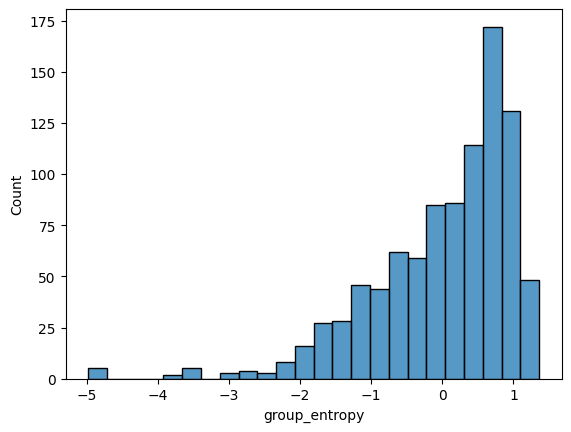

In [18]:
sns.histplot(zgroup)

## 8. Compute correct rate for each quiz(each QuizId) in metadata

In [19]:
def quiz_entropy(input_df):
    tempDF = input_df.groupby('QuizId')['IsCorrect'].value_counts(normalize=True)

    tempDF_list=[]
    index = list(sorted(set(input_df['QuizId'].tolist())))
    
    for i in index:
        tempDF_list.append(multinomial.entropy(1,tempDF[i]))

    tempDF = pd.Series(tempDF_list, index=index, dtype=float, name='quizIdValue')

    score = 0
    for i in tempDF.index:
        cut_df = input_df[input_df['QuizId']==i]
        score += tempDF[i] * (cut_df.shape[0]/input_df.shape[0])
    return score
quiz_entropies = {}



In [20]:
for i in new_df.QuestionId.unique():
    input_df = new_df[new_df['QuestionId']==i]
    quiz_entropies[i] = quiz_entropy(input_df)
template['quiz_entropy'] = template['QuestionId'].apply(lambda x: quiz_entropies[x])
template['zquiz_entropy'] = (template['quiz_entropy']-template['quiz_entropy'].mean())/template['quiz_entropy'].std()
zquiz = template['zquiz_entropy']

print(zquiz)

0      0.007692
1      0.611667
2      0.344118
3     -1.986184
4      0.313453
         ...   
943    0.700696
944   -3.621256
945    0.625783
946    0.833270
947    0.380039
Name: zquiz_entropy, Length: 948, dtype: float64


<Axes: xlabel='zquiz_entropy', ylabel='Count'>

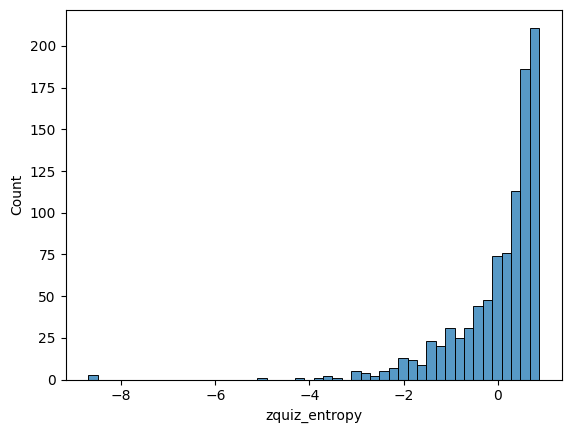

In [21]:
sns.histplot(zquiz)

## 9. Show calcuated rank by each features

In [22]:
rankDF = pd.DataFrame()
rankDF['Selectivity_Rank'] = answerValue_entropies.rank(method='first',ascending=False).astype('int')
rankDF['CorrectRate_Rank'] = isCorrect_entropies.rank(method='first',ascending=False).astype('int')
rankDF['Difficulty_Rank'] = difficulty.rank(method='first',ascending=False).astype('int')
rankDF['Confidence_Rank'] = zconfidence.rank(method='first',ascending=True).astype('int')
rankDF['Group_Rank'] = zgroup.rank(method='first',ascending=False).astype('int')
rankDF['Quiz_Rank'] = zquiz.rank(method='first',ascending=False).astype('int')

rankDF

,Selectivity_Rank,CorrectRate_Rank,Difficulty_Rank,Confidence_Rank,Group_Rank,Quiz_Rank
0,484,247,527,188,331,617
1,844,293,710,422,730,283
2,124,481,357,192,92,471
3,908,915,64,855,823,909
4,150,405,389,63,84,494
...,...,...,...,...,...,...
943,780,274,891,815,158,186
944,188,938,7,284,934,942
945,331,324,492,368,48,268
946,397,178,869,358,864,34


## 10. Get prediction result by 'evaluate' function & Get actual ground truth by 'evaluate_truth' function

In [23]:
# Get prediction of result of truth file.
def evaluate(truth, submission):
    # extract ranking
    left = list(truth.left)
    right = list(truth.right)

    submission_left = []
    submission_right = []
    submission_preference = []
    for idx in range(len(left)):
        submission_left.append(left[idx])
        submission_right.append(right[idx])
        ranking_left = submission[submission.QuestionId==left[idx]].ranking.values[0]
        ranking_right = submission[submission.QuestionId==right[idx]].ranking.values[0]
        preference = 1 if ranking_left < ranking_right else 2
        submission_preference.append(preference)
    
    return submission_preference

In [24]:
# To measure accuracy, we need to know actucal rank. So get actual rank by evaluate_truth
def evaluate_truth(truth):
    T1_ALR = list(truth.T1_ALR)
    T2_CL = list(truth.T2_CL)
    T3_GF = list(truth.T3_GF)
    T4_MQ = list(truth.T4_MQ)
    T5_NS =  list(truth.T5_NS)
    truth_preference = []
    for i,score in enumerate(T1_ALR):
        if math.isnan(T1_ALR[i]):
            sumEval = 0
            sumEval = T2_CL[i] + T3_GF[i] + T4_MQ[i]+ T5_NS[i]
            truth_preference.append(round(sumEval/4))    
        elif math.isnan(T2_CL[i]):
            sumEval = 0
            sumEval = T1_ALR[i] + T3_GF[i] + T4_MQ[i]+ T5_NS[i]
            truth_preference.append(round(sumEval/4))    
        elif math.isnan(T3_GF[i]):
            sumEval = 0
            sumEval = T1_ALR[i] + T2_CL[i] + T4_MQ[i]+ T5_NS[i]
            truth_preference.append(round(sumEval/4))    
        elif math.isnan(T4_MQ[i]):
            sumEval = 0
            sumEval = T1_ALR[i] + T2_CL[i] + T3_GF[i] + T5_NS[i]
            truth_preference.append(round(sumEval/4))    
        elif math.isnan(T5_NS[i]):
            sumEval = 0
            sumEval = T1_ALR[i] + T2_CL[i] + T3_GF[i] + T4_MQ[i]
            truth_preference.append(round(sumEval/4))    
        else:
            sumEval = 0
            sumEval = T1_ALR[i] + T2_CL[i] + T3_GF[i] + T4_MQ[i] + T5_NS[i]
            truth_preference.append(round(sumEval/5))   
        
    
    return truth_preference

## 11. Check combination of features by 'subset_selection' function & Find best subset by 'find_bestDF' function

In [25]:
def subset_selection(rankDF, k):
    df_columns = rankDF.columns.copy().tolist()
    temp_df = pd.DataFrame(index=rankDF.index)
    for subset in itertools.combinations(df_columns, k):
        df = pd.Series([0 for i in range(0,len(rankDF))],index=rankDF.index)
        columnName=""
        for i in subset:
            columnName = columnName + "_" + i
            if(i=="Confidence_Rank"):
                df = df + rankDF[i]
            else:
                df = df + rankDF[i]
        
        df=df/k
        df = df.rank(method='first', ascending=True).astype('int')
        temp_df[columnName] = df

    return temp_df

In [26]:
# best subset selection
def find_bestDF(eval_validation):
    col = ""
    percent_max = 0
    df_subsets = pd.DataFrame()
    for idx in range(1,len(rankDF.columns)+1):
        temp_df = subset_selection(rankDF, idx)
        df_subsets = pd.concat([df_subsets,temp_df],axis=1)
        for name in temp_df.columns.tolist():
            df = pd.DataFrame({'QuestionId':temp_df[name].index,'ranking':temp_df[name].values})
            eval_result = evaluate(eval_validation, df)
            truth_preference = evaluate_truth(eval_validation)

            wrong_num = 0
            for i, score in enumerate(truth_preference):
                if truth_preference[i] != eval_result[i]:
                    wrong_num = wrong_num + 1
            percent = (len(truth_preference)-wrong_num)/len(truth_preference) * 100
            if percent >= percent_max:
                percent_max = percent
                col = name
                best_df = temp_df[name]

            #print(eval_result)
            print(f'Accuracy for validation of {name} is {percent}%')

    best_df_cands = pd.DataFrame()
    for idx in range(1,len(rankDF.columns)+1):
        temp_df = subset_selection(rankDF, idx)
        for name in temp_df.columns.tolist():
            df = pd.DataFrame({'QuestionId':temp_df[name].index,'ranking':temp_df[name].values})
            eval_result = evaluate(eval_validation, df)
            truth_preference = evaluate_truth(eval_validation)

            wrong_num = 0
            for i, score in enumerate(truth_preference):
                if truth_preference[i] != eval_result[i]:
                    wrong_num = wrong_num + 1
            percent = (len(truth_preference)-wrong_num)/len(truth_preference) * 100
            if percent == percent_max:
                best_df_cands[name] = temp_df[name]
            
    return best_df_cands, df_subsets    # best_df_cands give highest accuracy features, df_subsets give every subset

In [27]:
eval_validation = pd.read_csv('./data/test_data/quality_response_remapped_public.csv')
best_df_cands, df_subsets = find_bestDF(eval_validation)

Accuracy for validation of _Selectivity_Rank is 84.0%
Accuracy for validation of _CorrectRate_Rank is 76.0%
Accuracy for validation of _Difficulty_Rank is 24.0%
Accuracy for validation of _Confidence_Rank is 76.0%
Accuracy for validation of _Group_Rank is 72.0%
Accuracy for validation of _Quiz_Rank is 76.0%
Accuracy for validation of _Selectivity_Rank_CorrectRate_Rank is 80.0%
Accuracy for validation of _Selectivity_Rank_Difficulty_Rank is 76.0%
Accuracy for validation of _Selectivity_Rank_Confidence_Rank is 88.0%
Accuracy for validation of _Selectivity_Rank_Group_Rank is 72.0%
Accuracy for validation of _Selectivity_Rank_Quiz_Rank is 72.0%
Accuracy for validation of _CorrectRate_Rank_Difficulty_Rank is 68.0%
Accuracy for validation of _CorrectRate_Rank_Confidence_Rank is 84.0%
Accuracy for validation of _CorrectRate_Rank_Group_Rank is 72.0%
Accuracy for validation of _CorrectRate_Rank_Quiz_Rank is 72.0%
Accuracy for validation of _Difficulty_Rank_Confidence_Rank is 56.00000000000001%


## 12. Show every validation results using each models(models that used each features).
### (We can find out there are 6 models showing same highest accuracy, 88% for each)

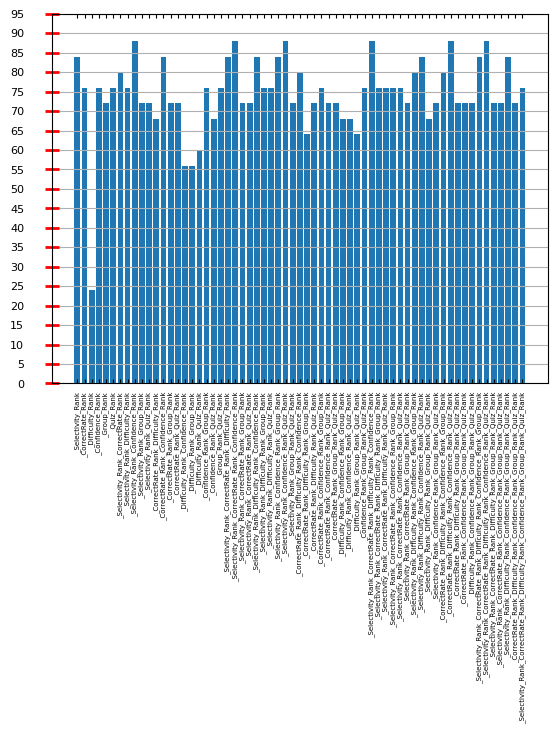

['_Selectivity_Rank', '_CorrectRate_Rank', '_Difficulty_Rank', '_Confidence_Rank', '_Group_Rank', '_Quiz_Rank', '_Selectivity_Rank_CorrectRate_Rank', '_Selectivity_Rank_Difficulty_Rank', '_Selectivity_Rank_Confidence_Rank', '_Selectivity_Rank_Group_Rank', '_Selectivity_Rank_Quiz_Rank', '_CorrectRate_Rank_Difficulty_Rank', '_CorrectRate_Rank_Confidence_Rank', '_CorrectRate_Rank_Group_Rank', '_CorrectRate_Rank_Quiz_Rank', '_Difficulty_Rank_Confidence_Rank', '_Difficulty_Rank_Group_Rank', '_Difficulty_Rank_Quiz_Rank', '_Confidence_Rank_Group_Rank', '_Confidence_Rank_Quiz_Rank', '_Group_Rank_Quiz_Rank', '_Selectivity_Rank_CorrectRate_Rank_Difficulty_Rank', '_Selectivity_Rank_CorrectRate_Rank_Confidence_Rank', '_Selectivity_Rank_CorrectRate_Rank_Group_Rank', '_Selectivity_Rank_CorrectRate_Rank_Quiz_Rank', '_Selectivity_Rank_Difficulty_Rank_Confidence_Rank', '_Selectivity_Rank_Difficulty_Rank_Group_Rank', '_Selectivity_Rank_Difficulty_Rank_Quiz_Rank', '_Selectivity_Rank_Confidence_Rank_Group

In [28]:
X=[]
Y=[]
for idx in df_subsets:
    model = df_subsets[idx]
    model = pd.DataFrame({'QuestionId':model.index,'ranking':model.values})
    eval_result = evaluate(eval_validation, model)
    truth_preference = evaluate_truth(eval_validation)

    wrong_num = 0
    for i, score in enumerate(truth_preference):
        if truth_preference[i] != eval_result[i]:
            wrong_num = wrong_num + 1
    percent = (len(truth_preference)-wrong_num)/len(truth_preference) * 100
    X.append(idx)
    Y.append(percent)
    #print(eval_result)

plt.bar(X,Y)
plt.xticks(X, rotation='vertical')
plt.tick_params(axis='x', direction='in', length=3, pad=6, labelsize=5, top=True)
plt.grid(axis='y')
plt.yticks(range(0,100,5))
plt.tick_params(axis='y', direction='inout', length=10, labelsize=8,pad=15, width=2, color='r')
plt.show()
print(X)
print(Y)


## 13. Show every test results that using models showed highest accuracy of validation result.

Accuracy for test with model _Selectivity_Rank_Confidence_Rank is 76.0%
Accuracy for test with model _Selectivity_Rank_CorrectRate_Rank_Confidence_Rank is 76.0%
Accuracy for test with model _Selectivity_Rank_Confidence_Rank_Quiz_Rank is 76.0%
Accuracy for test with model _Selectivity_Rank_CorrectRate_Rank_Difficulty_Rank_Confidence_Rank is 72.0%
Accuracy for test with model _CorrectRate_Rank_Difficulty_Rank_Confidence_Rank_Quiz_Rank is 56.00000000000001%
Accuracy for test with model _Selectivity_Rank_CorrectRate_Rank_Difficulty_Rank_Confidence_Rank_Quiz_Rank is 68.0%


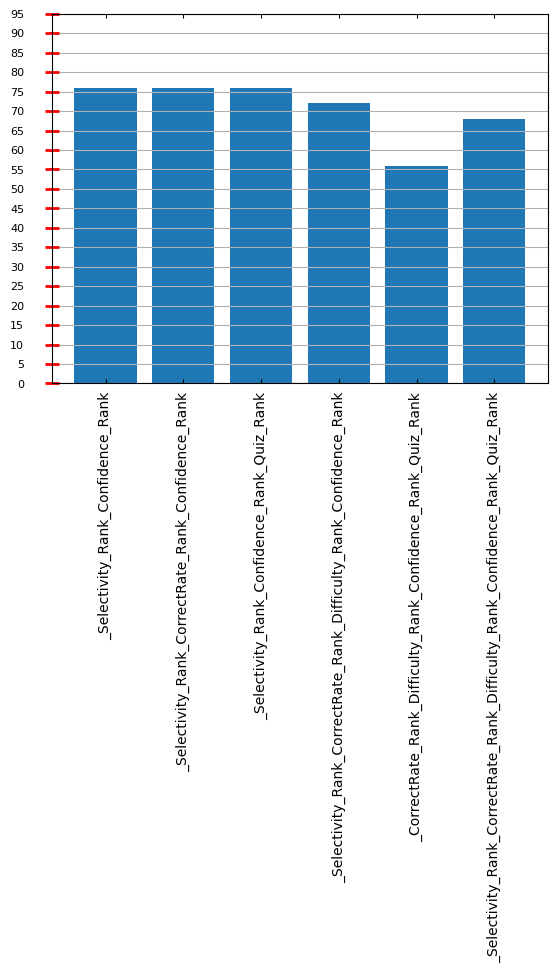

In [29]:
eval_test = pd.read_csv('./data/test_data/quality_response_remapped_private.csv')

X=[]
Y=[]
for idx in best_df_cands:
    model=best_df_cands[idx]
    model = pd.DataFrame({'QuestionId':model.index,'ranking':model.values})
    eval_result = evaluate(eval_test, model)
    truth_preference = evaluate_truth(eval_test)

    wrong_num = 0
    for i, score in enumerate(truth_preference):
        if truth_preference[i] != eval_result[i]:
            wrong_num = wrong_num + 1
    percent = (len(truth_preference)-wrong_num)/len(truth_preference) * 100
    X.append(idx)
    Y.append(percent)

    #print(eval_result)
    print(f'Accuracy for test with model {idx} is {percent}%')

plt.bar(X,Y)
plt.xticks(X, rotation=90)
plt.tick_params(axis='x', direction='in', length=3, pad=6, top=True)
plt.grid(axis='y')
plt.yticks(range(0,100,5))
plt.tick_params(axis='y', direction='inout', length=10, labelsize=8,pad=15, width=2, color='r')
plt.show()

## 14. Save Rank(Rank that we got by using '_Selectivity_Rank_Confidence_Rank_Quiz_Rank' features)

In [30]:
template = pd.read_csv('./submission/template.csv')
template['ranking']=best_df_cands['_Selectivity_Rank_Confidence_Rank_Quiz_Rank']
template.to_csv('./submission/20170502.csv', index=False)

## 15. Evaluation(Test)

In [31]:
# load evaluators' score on "validation" set
#https://competitions.codalab.org/forums/22145/4564/
eval_test = pd.read_csv('./data/test_data/quality_response_remapped_private.csv')

model = pd.read_csv('./submission/20170502.csv')
# df = pd.DataFrame({'QuestionId':temp_df.index,'ranking':temp_df.values})
# df['QuestionId'] = bestDF.index
# df['ranking'] = bestDF.values
eval_result = evaluate(eval_test, model)
truth_preference = evaluate_truth(eval_test)

wrong_num = 0
for i, score in enumerate(truth_preference):
    if truth_preference[i] != eval_result[i]:
        wrong_num = wrong_num + 1
percent = (len(truth_preference)-wrong_num)/len(truth_preference) * 100

#print(eval_result)
print(f'Accuracy for test is {percent}%')


Accuracy for test is 76.0%
